# Designing GLM with additional confounds for NLA Subject Level Stat Analysis for a Pain-stimulus task-based fMRI experiment to study effects of Saline vs Lidocaine

Importing all the necessary OS, shell scripting and imaging operations:

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
import subprocess
import re
import glob
import argparse
import shutil
import json
import nibabel as nib
from nilearn import plotting
from nilearn.image import load_img, mean_img, new_img_like, resample_to_img, threshold_img, high_variance_confounds
from nilearn import datasets
from nilearn import maskers
from nilearn import signal

from nilearn.glm.first_level import FirstLevelModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_epi, plot_contrast_matrix
from nilearn.plotting import plot_design_matrix, plot_anat, plot_img, plot_roi


## Preparing the design matrices from FSL FEAT results for a consolidated GLM matrix with new confounds

File path and directories used:

funcpath = '/localpath/func/' containing all filtered functional data 


conf = '/localpath/confounds/' containing TSV files that have all regressor columns : Pain, Pain_der, #6_motionparameters, #n_MotionOutliers, #5_Compcor_HVC


fsl_des = '/localpath/design/' containing TSV files that have data from design.mat from FSL feat results : Pain, Pain_der, #6_motionparameters, #n_MotionOutliers 


hvc = '/localpath/design/' containing TSV files that have data from high_variance_confounds : #5_Compcor_HVC

In [ ]:
# list all the files with the suffix mp-confoundsMtx.txt in the path /serverpath/NLA*/Pain_func*
mp_path = glob.glob('/serverpath/NLA*/Pain_func*/mp-confoundsMtx.txt')
# print(mp_path)
mp_path.sort()
mp_path

[]

Since no motion outliers are detected for a fdrms threshold of over 1.5 mm, including only the 6 pre-computed motion parameters from motion analysis in the GLM regression.

In [31]:
# list the files in a directory /localpath/ in the format NLA*.nii.gz
def list_files(path):
    files = glob.glob(path + 'NLA*.nii.gz')
    return files

funcpath = '/localpath/func/'
files = list_files(funcpath)

In [ ]:
# compute the mean of the files
from nilearn.image import mean_img
mean_img_func = mean_img(files)

# save the mean image as a nifti file
mean_img_func.to_filename('/localpath/mean_img_func.nii.gz')

In [32]:
# list the basename of the files 
def list_basename(files):
    basenames = [os.path.basename(x) for x in files]
    return basenames

basenames = list_basename(files)
basenames

['NLA08_Pain1_Pre_10262023_124336.nii.gz',
 'NLA15_Pain1_Pre_10252023_144351.nii.gz',
 'NLA10_Pain2_Pre_10252023_144351.nii.gz',
 'NLA11_Pain1_Pre_10252023_144351.nii.gz',
 'NLA14_Pain2_Pre_10252023_144351.nii.gz',
 'NLA26_Pain1_Pre_10252023_144351.nii.gz',
 'NLA09_Pain2_Pre_10262023_124336.nii.gz',
 'NLA19_Pain1_Pre_10252023_144351.nii.gz',
 'NLA04_Pain1_Pre_10262023_124336.nii.gz',
 'NLA05_Pain2_Pre_10262023_124336.nii.gz',
 'NLA29_Pain1_Pre_10252023_212459.nii.gz',
 'NLA33_Pain2_Pre_10252023_212459.nii.gz',
 'NLA34_Pain2_Pre_10252023_212459.nii.gz',
 'NLA31_Pain1_Pre_10252023_212459.nii.gz',
 'NLA02_Pain2_Pre_10262023_124336.nii.gz',
 'NLA07_Pain1_Pre_10262023_124336.nii.gz',
 'NLA03_Pain1_Pre_10262023_124336.nii.gz',
 'NLA35_Pain1_Pre_10252023_212459.nii.gz',
 'NLA16_Pain1_Pre_10252023_144351.nii.gz',
 'NLA24_Pain2_Pre_10252023_144351.nii.gz',
 'NLA13_Pain2_Pre_10252023_144351.nii.gz',
 'NLA21_Pain1_Pre_10252023_144351.nii.gz',
 'NLA20_Pain2_Pre_10252023_144351.nii.gz',
 'NLA12_Pai

In [18]:
# replace the .nii.gz with .feat
def replace_feat(basenames):
    feat = [x.replace('.nii.gz', '.feat') for x in basenames]
    return feat

feat = replace_feat(basenames)
feat


['NLA08_Pain1_Pre_10262023_124336.feat',
 'NLA15_Pain1_Pre_10252023_144351.feat',
 'NLA10_Pain2_Pre_10252023_144351.feat',
 'NLA11_Pain1_Pre_10252023_144351.feat',
 'NLA14_Pain2_Pre_10252023_144351.feat',
 'NLA26_Pain1_Pre_10252023_144351.feat',
 'NLA09_Pain2_Pre_10262023_124336.feat',
 'NLA19_Pain1_Pre_10252023_144351.feat',
 'NLA04_Pain1_Pre_10262023_124336.feat',
 'NLA05_Pain2_Pre_10262023_124336.feat',
 'NLA12_Pain2_corrected_NLA_12_4stim.feat',
 'NLA29_Pain1_Pre_10252023_212459.feat',
 'NLA33_Pain2_Pre_10252023_212459.feat',
 'NLA34_Pain2_Pre_10252023_212459.feat',
 'NLA31_Pain1_Pre_10252023_212459.feat',
 'NLA02_Pain2_Pre_10262023_124336.feat',
 'NLA07_Pain1_Pre_10262023_124336.feat',
 'NLA03_Pain1_Pre_10262023_124336.feat',
 'NLA35_Pain1_Pre_10252023_212459.feat',
 'NLA16_Pain1_Pre_10252023_144351.feat',
 'NLA24_Pain2_Pre_10252023_144351.feat',
 'NLA13_Pain2_Pre_10252023_144351.feat',
 'NLA21_Pain1_Pre_10252023_144351.feat',
 'NLA20_Pain2_Pre_10252023_144351.feat',
 'NLA12_Pain1

In [19]:
feat = ['NLA08_Pain1_Pre_10262023_124336.feat',
 'NLA15_Pain1_Pre_10252023_144351.feat',
 'NLA10_Pain2_Pre_10252023_144351.feat',
 'NLA11_Pain1_Pre_10252023_144351.feat',
 'NLA14_Pain2_Pre_10252023_144351.feat',
 'NLA26_Pain1_Pre_10252023_144351.feat',
 'NLA09_Pain2_Pre_10262023_124336.feat',
 'NLA19_Pain1_Pre_10252023_144351.feat',
 'NLA04_Pain1_Pre_10262023_124336.feat',
 'NLA05_Pain2_Pre_10262023_124336.feat',
 'NLA12_Pain2_corrected_NLA_12_4stim.feat',
 'NLA29_Pain1_Pre_10252023_212459.feat',
 'NLA33_Pain2_Pre_10252023_212459.feat',
 'NLA34_Pain2_Pre_10252023_212459.feat',
 'NLA31_Pain1_Pre_10252023_212459.feat',
 'NLA02_Pain2_Pre_10262023_124336.feat',
 'NLA07_Pain1_Pre_10262023_124336.feat',
 'NLA03_Pain1_Pre_10262023_124336.feat',
 'NLA35_Pain1_Pre_10252023_212459.feat',
 'NLA16_Pain1_Pre_10252023_144351.feat',
 'NLA24_Pain2_Pre_10252023_144351.feat',
 'NLA13_Pain2_Pre_10252023_144351.feat',
 'NLA21_Pain1_Pre_10252023_144351.feat',
 'NLA20_Pain2_Pre_10252023_144351.feat',
 'NLA12_Pain1_Pre_10252023_144351.feat',
 'NLA25_Pain1_Pre_10252023_144351.feat',
 'NLA17_Pain2_Pre_10252023_144351.feat',
 'NLA27_Pain2_Pre_10262023_161016.feat',
 'NLA36_Pain2_Pre_11282023_114924.feat',
 'NLA04_Pain2_Pre_10262023_124336.feat',
 'NLA19_Pain2_Pre_10252023_144351.feat',
 'NLA33_Pain1_Pre_10252023_212459.feat',
 'NLA29_Pain2_Pre_10252023_212459.feat',
 'NLA05_Pain1_Pre_10262023_124336.feat',
 'NLA27_Pain1_Pre_10252023_144351.feat',
 'NLA15_Pain2_Pre_10252023_144351.feat',
 'NLA10_Pain1_Pre_10252023_144351.feat',
 'NLA08_Pain2_Pre_10262023_124336.feat',
 'NLA09_Pain1_Pre_10262023_124336.feat',
 'NLA11_Pain2_Pre_10252023_144351.feat',
 'NLA14_Pain1_Pre_10252023_144351.feat',
 'NLA26_Pain2_Pre_10252023_144351.feat',
 'NLA16_Pain2_Pre_10252023_144351.feat',
 'NLA24_Pain1_Pre_10252023_144351.feat',
 'NLA13_Pain1_Pre_10252023_144351.feat',
 'NLA21_Pain2_Pre_10252023_144351.feat',
 'NLA36_Pain1_Pre_11282023_114924.feat',
 'NLA20_Pain1_Pre_10252023_144351.feat',
 'NLA12_Pain2_Pre_10252023_144351.feat',
 'NLA25_Pain2_Pre_10252023_144351.feat',
 'NLA17_Pain1_Pre_10252023_144351.feat',
 'NLA02_Pain1_Pre_10262023_124336.feat',
 'NLA07_Pain2_Pre_10262023_124336.feat',
 'NLA34_Pain1_Pre_10252023_212459.feat',
 'NLA31_Pain2_Pre_10252023_212459.feat',
 'NLA35_Pain2_Pre_10252023_212459.feat',
 'NLA03_Pain2_Pre_10262023_124336.feat']

In [21]:
# if the folder is present in the path /serverpath/NLA*/Pain_func*, then copy the design.mat file to the folder /localpath/func/
def copy_mat(feat):
    for i in feat:
        des_mtx = glob.glob('/serverpath/NLA*/Pain_func*/' + i + '/design.mat')
        shutil.copy(des_mtx[0], '/localpath/func/' + i + '_design.mat')


copy_mat(feat)


In [22]:
# convert all the .mat files to .tsv files
def convert_mat(feat):
    for i in feat:
        mat = np.loadtxt('/localpath/func/' + i + '_design.mat', skiprows=5)
        df = pd.DataFrame(mat)
        # headers are in the order of Pain, Pain_derivative, 6_MOtionParameters, n_MotionOutliers
        df.to_csv('/localpath/func/' + i[:-5] + '_design.tsv', sep='\t', index=False, header=False)

convert_mat(feat)

The cell below takes the high variance data as confounds computed using the nilearn function high_variance_confounds. It serves to account for the Compcor components in the filtered functional data from FSL preprocessing.


In [ ]:
# list the .tsv files in the directory /localpath/hvc
path = '/localpath/'
hvc_files = glob.glob(path + 'hvc/*_hvc.tsv')
hvc_files.sort()
hvc_files

In [198]:
len('/localpath/hvc/NLA36_Pain2_Pre_11282023_114924_hvc.tsv')

79

In [208]:
fslpath = '/serverpath/HVC/'

# get all files in fslpath directory
def list_files(path):
    files = glob.glob(path + '*.txt')
    return files

hvc_files_fsl = list_files(fslpath)


In [ ]:
hvc_files_fsl
hvc_files

t = os.path.basename(hvc_files[0])
t[:11]

In [217]:
# preparation for FSL GUI FirstLevel Stats: save the TSV files as txt files 
for i in range(len(hvc_files)):
    df = pd.read_csv(hvc_files[i], sep='\t', header=None)
    t = os.path.basename(hvc_files[i])
    df.to_csv(fslpath + t[:11] + '_hvc.txt', sep='\t', index=False, header=False)



The HVC data are stored as FSL compatible .txt format to provide in the GUI for appending to the previously designed GLM matrix for their corresponding functional data.

In [ ]:
design_files = glob.glob(path + '/design/*_design.tsv')
design_files.sort()


## New TSVs with old GLM with HVC data combined as new regressors

In [29]:
# for every corresponding file in the hvc_files and design_files, concatenate the two files and save it as a new TSV file 
# in the directory /localpath/confounds/
def concat_files(hvc_files, design_files):
    for i in range(len(hvc_files)):
        hvc = pd.read_csv(hvc_files[i], sep='\t', header=None)
        design = pd.read_csv(design_files[i], sep='\t', header=None)
        concat = pd.concat([design, hvc], axis=1)
        concat.to_csv(path + 'confounds/' + os.path.basename(hvc_files[i])[:-8] + '_confounds.tsv', sep='\t', index=False, header=False)

concat_files(hvc_files, design_files)


Extract a subset of functional data and confounds data for nilearn's GLM modeling:

In [163]:
files_trial = ['/localpath/func/NLA04_Pain1_Pre_10262023_124336.nii.gz',
 '/localpath/func/NLA04_Pain2_Pre_10262023_124336.nii.gz',
 '/localpath/func/NLA05_Pain1_Pre_10262023_124336.nii.gz',
 '/localpath/func/NLA05_Pain2_Pre_10262023_124336.nii.gz']

In [ ]:
conf = glob.glob(path + '/confounds/*_confounds.tsv')
conf.sort()
conf

In [ ]:
design_files

In [169]:
conf_trial = ['/localpath/confounds/NLA04_Pain1_Pre_10262023_124336_confounds.tsv',
 '/localpath/confounds/NLA04_Pain2_Pre_10262023_124336_confounds.tsv',
 '/localpath/confounds/NLA05_Pain1_Pre_10262023_124336_confounds.tsv',
 '/localpath/confounds/NLA05_Pain2_Pre_10262023_124336_confounds.tsv']

# fsl_des = ['/localpath/design/NLA04_Pain1_Pre_10262023_124336_design.tsv',
#  '/localpath/design/NLA04_Pain2_Pre_10262023_124336_design.tsv',
#  '/localpath/design/NLA05_Pain1_Pre_10262023_124336_design.tsv',
#  '/localpath/design/NLA05_Pain2_Pre_10262023_124336_design.tsv']

The First Level Modeling accepts a collective dataframe of the individual dataframes from TSV files for confounds. The trial dataframe has the corresponding information in the sequence of the list of the functional files given as input to the model. It can have a custom number of regressor columns for each functional run in case of the presence of motion outlier regressors based on the particular fMRI run.

In [178]:
des_trials = [pd.read_csv(x, sep='\t', header=None) for x in conf_trial]
des_trials

[           0         1         2         3         4         5         6   \
 0    0.000432  0.001321  0.000726 -0.000476  0.000012  0.020656  0.029362   
 1    0.001945  0.001217  0.000891 -0.000265 -0.000028  0.007501 -0.100906   
 2    0.003251  0.000965  0.000649 -0.000144 -0.000120  0.003583 -0.087700   
 3    0.004261  0.000634 -0.000450  0.000155 -0.000227 -0.012286 -0.048722   
 4    0.004904  0.000235 -0.000631  0.000173 -0.000112 -0.011101  0.015213   
 ..        ...       ...       ...       ...       ...       ...       ...   
 220  0.031672  0.004728  0.000571  0.000001  0.000057  0.002154 -0.077414   
 221  0.036030  0.003605  0.000272 -0.000014 -0.000047 -0.004087 -0.117642   
 222  0.039272  0.002497  0.000020  0.000034 -0.000030 -0.003919 -0.002073   
 223  0.041413  0.001403  0.000034  0.000107 -0.000016  0.001866  0.035468   
 224  0.042468  0.000860 -0.000013 -0.000116 -0.000095 -0.002001  0.111564   
 
            7         8         9         10        11        

In [53]:
# make a list of dataframes from the confounds files
def list_df(path):
    conf = glob.glob(path + 'confounds/*_confounds.tsv')
    conf.sort()
    df_list = [pd.read_csv(x, sep='\t', header=None) for x in conf]
    return df_list

design_fsl_hvc = list_df(path)


In [182]:
len(des_trials)
des_trials[1].shape[1]

13

In [172]:
statspath = '/localpath/stats/'

Average of the functional data for underlay; used interchangeably with the anatomical underlay for stat maps

In [173]:
mean_img_func = mean_img(files_trial)

## Running First Level Model with added HVC confounds

nilearn finds errors with multicollinearity when there are seemingly one or more columns in the regressors that are linear combination of others. VIF (Variance Inflation Factor) uses statsmodel from sklearn to detect columns with VIF > 5 (as suggested by GitHub Copilot's snippet) in the trial run below.

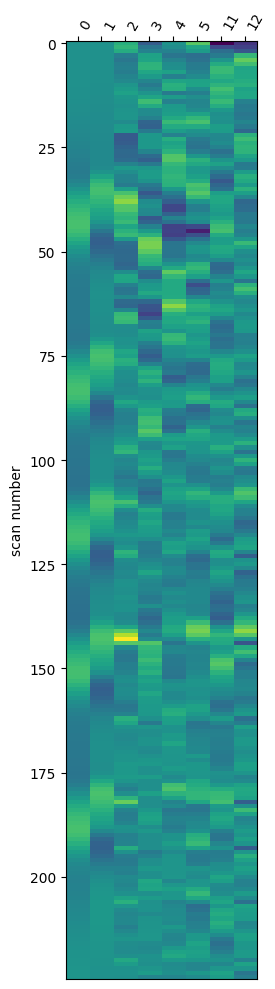

/usr/local/lib/python3.11/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


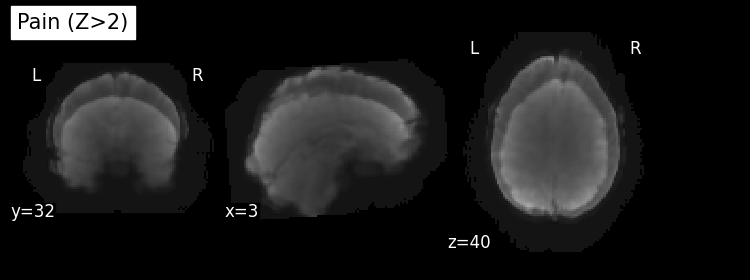

Dropping columns with high VIF: [ 2  3  5  6  7  8 10]


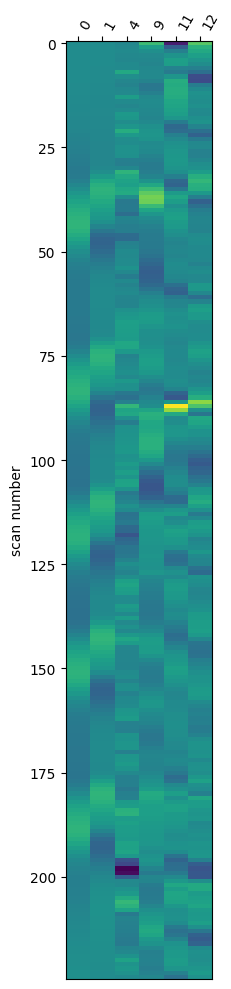

/usr/local/lib/python3.11/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


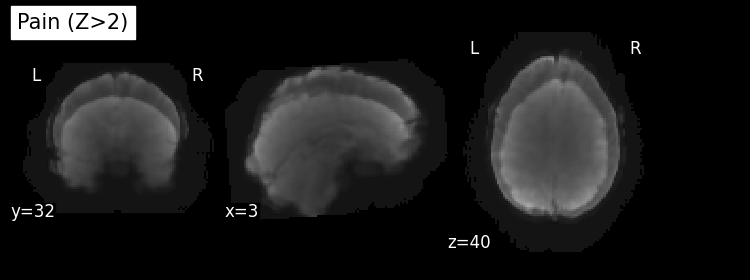

Dropping columns with high VIF: [ 2  7 10 11]


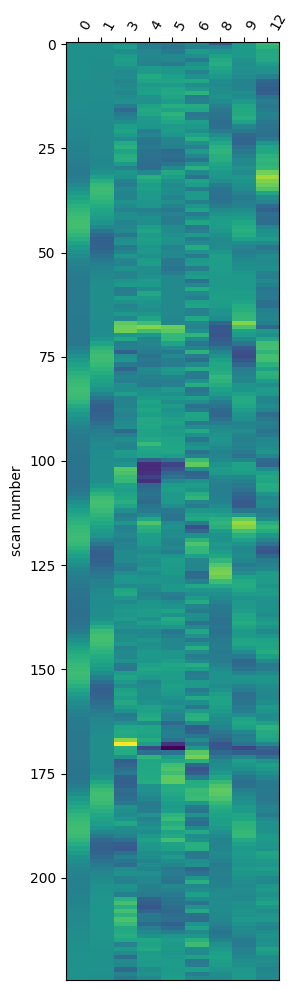

/usr/local/lib/python3.11/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


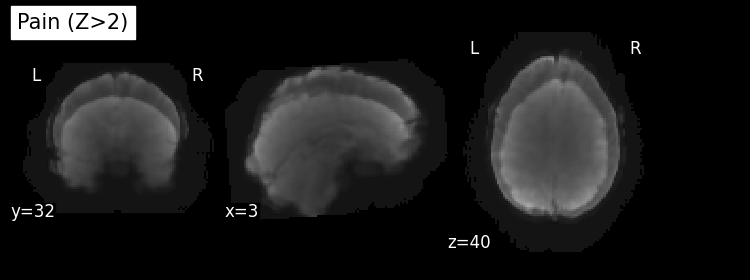

Dropping columns with high VIF: [2 6 7 8 9]


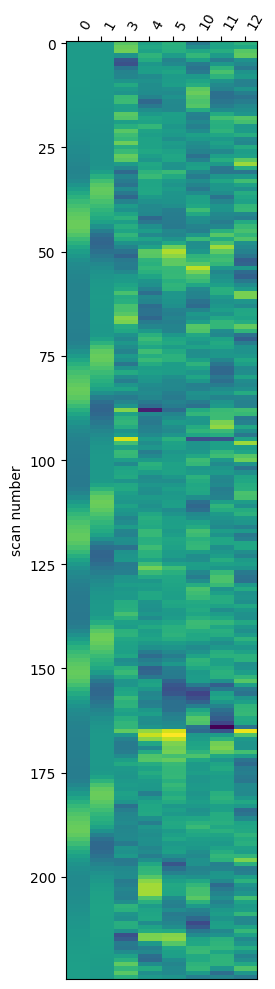

/usr/local/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


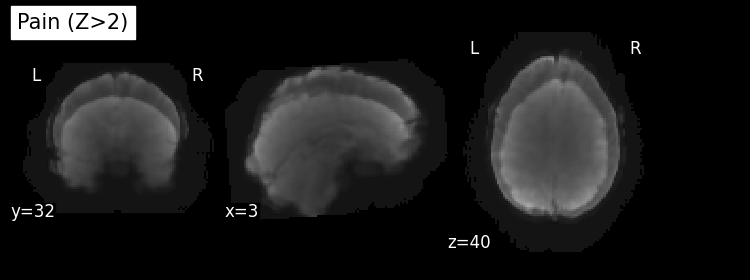

In [184]:
# looping through the functional data and fitting the GLM model
for i in range(len(files_trial)):
    # save the first 5 charaters of the file name as a subject_id string
    subject_id = os.path.basename(files_trial[i])[:11] 
    glm_model = FirstLevelModel(subject_label=subject_id, t_r=0.8, hrf_model='spm+derivative',
                                drift_model='polynomial', noise_model='ols', standardize=False, signal_scaling=False)

    # Identifying multicollinearity using VIF (Variance Inflation Factor) and dropping columns with VIF > 5
    vif = pd.DataFrame()
    vif["conf_columns"] = des_trials[i].columns # independent variables
    vif["VIF"] = [variance_inflation_factor(des_trials[i].values, j) for j in range(des_trials[i].shape[1])]

    # Drop columns with VIF > 5 (this is just a commonly used value, adjust according to your needs)
    high_vif_columns = vif[vif["VIF"] > 5]["conf_columns"]

    if len(high_vif_columns) > 0:
        des_trials[i] = des_trials[i].drop(columns=high_vif_columns)
        # print the statement to drop the columns
        print("Dropping columns with high VIF: " + str(high_vif_columns.values))


    # plot the design matrix using plot_design_matrix
    plot_design_matrix(des_trials[i])
    plt.show()

    # glm_model = glm_model.fit(files, design_matrices=design_fsl_hvc)
    glm_model = glm_model.fit(files_trial[i], design_matrices=des_trials[i])

    # making a dictionary of conditions
    ncols = des_trials[i].shape[1]

    conditions = {"Pain": np.zeros(ncols), "rest": np.zeros(ncols)}
    conditions["Pain"][0] = 1
    conditions["rest"][1] = 1

    pain_minus_rest = conditions["Pain"] - conditions["rest"]

    # saving the stat maps
    z_map = glm_model.compute_contrast(pain_minus_rest, output_type="z_score")
    # z_map = glm_model.compute_contrast(conditions["Pain"], output_type="z_score")
    # p_map = glm_model.compute_contrast(conditions["Pain"], output_type="p_value")
    # t_map = glm_model.compute_contrast(conditions["Pain"], output_type="stat")

    # save the z_map as a nifti file by replacing the suffix with _z_map.nii.gz in the folder statspath
    # z_map.to_filename(statspath + os.path.basename(files_trial[i])[:-7] + '_z_map.nii.gz')
    z_map.to_filename(statspath + subject_id + '_z_map_pain.nii.gz')

    # plotting the stat maps
    plot_stat_map(
    z_map,
    bg_img=mean_img_func,
    # bg_img='/serverpath/NLA36/Anat/NLA36_T1_anat_brain.nii.gz',
    # bg_img=bkg,
    threshold=2.0,
    display_mode="ortho",
    cut_coords=[3, 32, 40],
    black_bg=True,
    draw_cross=False,
    title="Pain (Z>2)",
    )
    plt.show()

    # plot_stat_map(
    # z_map,
    # display_mode="mosaic",
    # title="Pain(Z>2)",
    # threshold=2.0,
    # # cut_coords=[3, 32, 40],
    # black_bg=True,
    # draw_cross=False,
    # # bg_img='/serverpath/NLA02/Anat/NLA02_T1_anat_brain.nii.gz')
    # bg_img=mean_img_func)
    # plt.show()

The statistical maps are saved as and when the GLM is fit for each run. The lines of code for plotting them can be separated into a different function for ease and modular scripting.

Since the resulting z_maps have unreliably less voxels of activation and error-prone due to apparent multicollinearity, the new GLM design files are provided as new confounds .txt files to the FSL fsf templates using the batch processing shell script.